In [2]:
from api_neurotask import *
import pandas as pd
import matplotlib.pyplot as plt
import pynapple as nap

### 1. Load and Filter Data

Before diving into the analysis, it's essential to load the dataset and preprocess it. In this step, we'll filter out non-reward trials to focus our analysis on the relevant data.

Remove trials with outcomes: Aborted (A), Incomplete (I), Failed (F)

Also, return the bin size of the dataset in ms

In [3]:
data = nap.load_file("001056/sub-Animal-1-&-2/sub-Animal-1-&-2.nwb")
df , bin = get_dataframe(data,filter_result=[b'R'])

/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Data loaded with bin size of 10.0 ms


In [4]:
data

sub-Animal-1-&-2
┍━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━┑
│ Keys              │ Type     │
┝━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━┥
│ spikes_counts     │ TsdFrame │
│ trial_id          │ Tsd      │
│ session           │ Tsd      │
│ datasetID         │ Tsd      │
│ animal            │ Tsd      │
│ result            │ Tsd      │
│ EventTarget_Onset │ Tsd      │
│ EventGo_cue       │ Tsd      │
│ EventBump         │ Tsd      │
│ target_dir        │ Tsd      │
│ hand_vel_y        │ Tsd      │
│ hand_vel_x        │ Tsd      │
│ hand_pos_y        │ Tsd      │
│ hand_pos_x        │ Tsd      │
│ bump_dir          │ Tsd      │
┕━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━┙

In [5]:
df.head()

,Neuron0,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,...,result,EventTarget_Onset,EventGo_cue,EventBump,target_dir,hand_vel_y,hand_vel_x,hand_pos_y,hand_pos_x,bump_dir
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,b'R',False,False,False,0.0,14.270410,-9.879614,-40.837310,-2.729025,1.570796
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,b'R',False,False,False,0.0,13.419577,-9.446477,-40.698774,-2.825641,1.570796
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,b'R',False,False,False,0.0,12.573560,-8.983446,-40.568888,-2.917859,1.570796
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,0.0,11.821613,-8.411639,-40.446963,-3.004936,1.570796
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,0.0,11.053716,-7.756530,-40.332516,-3.085807,1.570796


### 2. Rebin Data for Analysis

The `rebin` function is designed to rebin a dataset by aggregating data points into larger bins based on a specified bin size. Here's a brief overview of how to use it:

The `rebin` function takes the following parameters:
- `dataset1`: The DataFrame containing the data to be rebinned.
- `prev_bin_size`: The original bin size of the data.
- `new_bin_size`: The desired bin size to aggregate data points into. This is the new bin size you want the data to be rebinned to.
- `reset` (optional): A boolean indicating whether to reset the index of the resulting DataFrame.

When called, the function aggregates data points within each bin based on the specified aggregation functions. The aggregation functions are determined based on the column names of the input DataFrame. For spiking data, the function aggregates by summing the values. For columns related to behavior, the function applies a custom decimation function to downsample the data. 


In [6]:
# Rebin the dataset with a bin size of 20 ms 
df20 = rebin(df,prev_bin_size = bin ,new_bin_size = 20)

In [7]:
df20

,session,trial_id,Neuron0,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,...,result,EventTarget_Onset,EventGo_cue,EventBump,target_dir,hand_vel_y,hand_vel_x,hand_pos_y,hand_pos_x,bump_dir
0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,b'R',False,False,False,0.000000,13.844993,-9.663045,-40.768042,-2.777333,1.570796
1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,0.000000,12.197587,-8.697542,-40.507926,-2.961398,1.570796
2,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,b'R',False,False,False,0.000000,10.629333,-7.434564,-40.279349,-3.122960,1.570796
3,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,b'R',False,False,False,0.000000,9.039913,-6.239253,-40.083160,-3.259433,1.570796
4,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,0.000000,7.627443,-5.119604,-39.916148,-3.373000,1.570796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361893,2,1386,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,b'R',False,False,False,1.570796,59.294004,11.951860,-27.398168,0.320557,0.000000
361894,2,1386,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,...,b'R',False,False,False,1.570796,57.145496,9.816891,-26.229608,0.539739,0.000000
361895,2,1386,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,b'R',False,False,False,1.570796,51.964747,6.463730,-25.133289,0.704709,0.000000
361896,2,1386,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,b'R',False,False,False,1.570796,44.039648,2.081319,-24.168594,0.791723,0.000000


### 3. Align to specific event

Before using the `align_event` function, it's essential to understand its purpose and how it operates. This function is designed to align events within a DataFrame based on a specified start event marker. Here's a brief overview of how to use it:

The `align_event` function takes the following parameters:
- `df`: The DataFrame containing the data.
- `bin_size`: the bin size of the data in ms.
- `start_event`: The event marker indicating the start of a trial or session.
- `offset_min` (optional): The minimum offset (in ms) to consider before the start_event.
- `offset_max` (optional): The maximum offset (in ms) to consider after the start_event.


Please note that for Dataset 1, it's not possible to align events since it doesn't contain event information.

In [8]:
[col for col in df.columns if col.startswith('Event')]

['EventTarget_Onset', 'EventGo_cue', 'EventBump']

In [9]:
t = align_event(df20, 'EventTarget_Onset', bin_size=20,offset_min=-20,offset_max=40)

In [10]:
t

,session,trial_id,Neuron0,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,...,result,EventTarget_Onset,EventGo_cue,EventBump,target_dir,hand_vel_y,hand_vel_x,hand_pos_y,hand_pos_x,bump_dir
116,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,b'R',NaN,False,False,0.000000,-1.936864,-1.749977,-32.451963,0.111210,1.570796
117,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',True,True,False,0.000000,1.249790,-0.079801,-32.457340,0.093195,1.570796
118,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,b'R',NaN,False,False,0.000000,3.423443,0.961891,-32.408668,0.103679,1.570796
119,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,b'R',NaN,False,False,0.000000,4.001144,1.019113,-32.330823,0.125254,1.570796
378,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,b'R',NaN,False,False,3.141593,0.185450,-5.327119,-32.338394,0.920466,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324168,2,1031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',NaN,False,False,3.926991,-1.184138,-0.090619,-35.233672,0.353955,0.000000
324439,2,1032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',NaN,False,False,3.926991,-0.231191,15.396076,-34.698562,-1.142190,2.356194
324440,2,1032,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,b'R',True,True,False,3.926991,-0.297402,13.231062,-34.703743,-0.854803,2.356194
324441,2,1032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',NaN,False,False,3.926991,-0.763108,10.433138,-34.713396,-0.617138,2.356194


### 4. Data split and model's inputs processing

 This function is designed to process a dataset, splitting it into training, validation, and testing sets, and optionally performing z-score normalization on the input data. Here's a brief overview of how to use it:

The `process_data` function takes the following parameters:

- `df` (pd.DataFrame): The DataFrame containing the data.
- `bins_before` (int): Number of bins before the output used for decoding.
- `training_range` (list): The range [start, end] for the training set.
- `valid_range` (list): The range [start, end] for the validation set.
- `testing_range` (list): The range [start, end] for the testing set.
- `behavior_columns` (list): List of columns containing behavioral data.
- `zscore` (bool): Whether to apply z-score normalization.


In [11]:
X_train_list, y_train_list, X_val_list, y_val_list, X_test_list, y_test_list = process_data(df20, bins_before=5, 
                                                 training_range=[0, 0.7], valid_range=[0.7, 0.8], testing_range=[0.8, 1], 
                                                 behavior_columns=['hand_vel_x', 'hand_vel_y'],zscore = False)

In [12]:
print("There are", sum(X.shape[2] for X in X_train_list), "unique neurons in the dataset in",len(X_train_list),"different sessions")

There are 461 unique neurons in the dataset in 4 different sessions


### 4. Exploratory Data Analysis

In this analysis, we are examining the unique number of trials per session for each animal. We use the pandas `groupby` function to group the data by the 'animal' and 'session' columns, and then calculate the number of unique trial IDs within each group using the `nunique` function. Finally, we reset the index of the resulting DataFrame and rename the column to 'unique_trials_per_session' for clarity. This analysis allows us to understand the distribution of trial counts across different sessions and animals in the dataset.


In [13]:
df.groupby(['animal', 'session'])['trial_id'].nunique().reset_index(name='unique_trials_per_session')

,animal,session,unique_trials_per_session
0,1,1,540
1,1,2,1279
2,2,1,483
3,2,2,464


#### 4.1 Velocity and Activty Visualization

Now we want to visualize one trial's neural activity alongside hand movement velocity. This code generates a raster plot and plots velocity data for a specific trial in the dataset. First, it filters the dataset to select the data for a particular trial based on the trial ID, session, and animal. It then identifies the columns corresponding to neurons and event timings. Using this information, it creates a raster plot to visualize the firing activity of neurons over time, with each row representing a different neuron. Additionally, it plots vertical lines to indicate the occurrence of specific events such as 'Go_cue', 'Target_Onset', and 'Bump_time'. The x-axis ticks are labeled with event indications to show the timing of these events. Furthermore, velocity data for the hand movement in the x and y directions is plotted on the secondary y-axis. This combined visualization provides insights into the neural activity and hand movement dynamics during the trial.


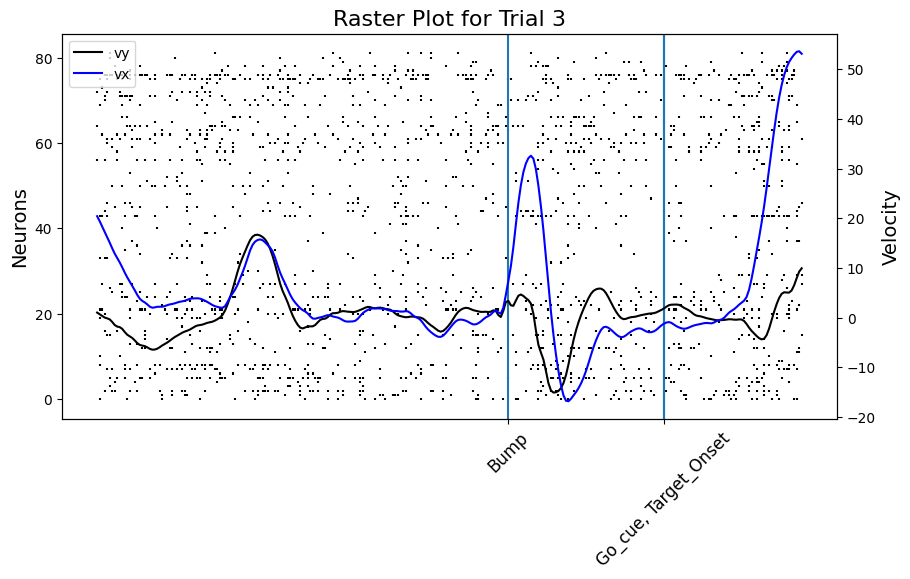

In [14]:

trial_id = 3
animal_id = 1
session_id = 1

trial_data = df[(df['trial_id'] == trial_id) & (df['session'] == session_id) & (df['animal'] == animal_id)]

# Select data for neurons
neuron_columns = [col for col in trial_data.columns if col.startswith('Neuron')]
neurons = neuron_columns[:]

# Identify event columns
event_columns = [col for col in df.columns if col.startswith('Event')]
#event_columns = ['Go_cue', 'Target_Onset', 'Bump_time']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot events per time for the selected neurons
for neuron in neurons:
    events = trial_data.index[trial_data[neuron] == 1].tolist()
    ax.eventplot(events, lineoffsets=neurons.index(neuron), linelengths=0.5, color='black')

# Plot event indications as vertical lines for each event type
colors = ['red', 'blue', 'green']
event_labels = []
event_positions = []

for idx, event_col in enumerate(event_columns):
    event_indices = trial_data.index[trial_data[event_col] == 1].tolist()
    for event_index in event_indices:
        ax.axvline(x=event_index, linestyle='-', label=event_col.replace("Event", ""))
        event_positions.append(event_index)
        event_labels.append(event_col.replace("Event", ""))

# Combine event labels for positions with multiple events
event_dict = {}
for pos, label in zip(event_positions, event_labels):
    if pos in event_dict:
        event_dict[pos].add(label)
    else:
        event_dict[pos] = {label}

# Sort events to ensure the ticks are in order
sorted_event_positions = sorted(event_dict.keys())
sorted_event_labels = [', '.join(event_dict[pos]) for pos in sorted_event_positions]

# Set x-axis ticks with event indications
ax.set_xticks(sorted_event_positions)
ax.set_xticklabels(sorted_event_labels, rotation=45, fontsize=12)

# Plot velocity data for y-axis
ax2 = ax.twinx()
ax2.plot(trial_data['hand_vel_y'], color='black', label='vy')
ax2.plot(trial_data['hand_vel_x'], color='blue', label='vx')

# Set y-axis label for velocity
ax2.set_ylabel('Velocity', fontsize=14)

# Increase font sizes for better readability
ax.set_ylabel('Neurons', fontsize=14)
ax.set_title(f'Raster Plot for Trial {trial_id}', fontsize=16)
plt.legend()
# Show plot
plt.show()


#### Get Individual Trial

It is also important to obtain and inspect individual trials. Here by defining the different conditions, we can analyse the desired trial.

In [261]:
dataset_id = 2
animal = 1
session = 2
trial_id = 10

conditions = (
    (df['datasetID'] == dataset_id) &
    (df['animal'] == animal) &
    (df['session'] == session) &
    (df['trial_id'] == trial_id)
)

filtered_df = df[conditions]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df



,Neuron0,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,...,result,EventTarget_Onset,EventGo_cue,EventBump,target_dir,hand_vel_y,hand_vel_x,hand_pos_y,hand_pos_x,bump_dir
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,1.570796,-0.403976,-0.401545,-32.490878,-0.911772,4.712389
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,1.570796,-0.366374,-0.430404,-32.494740,-0.915998,4.712389
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,b'R',False,False,False,1.570796,-0.432111,-0.378845,-32.498549,-0.920100,4.712389
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,1.570796,-0.743582,-0.299784,-32.504231,-0.923485,4.712389
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,b'R',False,False,False,1.570796,-1.176476,-0.245126,-32.513833,-0.926187,4.712389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,1.570796,18.537476,-12.479032,-24.155420,0.169403,4.712389
214,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,b'R',False,False,False,1.570796,15.853336,-13.126880,-23.983730,0.041009,4.712389
215,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,b'R',False,False,False,1.570796,13.498249,-13.391352,-23.837270,-0.091857,4.712389
216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,b'R',False,False,False,1.570796,11.541977,-13.388318,-23.712458,-0.225948,4.712389


In [284]:
dataset_id = 2
animal = 1
session = 1

conditions = (
    (df['datasetID'] == dataset_id) &
    (df['animal'] == animal) &
    (df['session'] == session)
)

filtered_df = df[conditions]
filtered_df = filtered_df.reset_index(drop=True)
np.unique(filtered_df['hand_vel_x']).shape


(144927,)

#### Tuning Curves

Now we want to visualize each neuron's activity versus some behaviour. To do so, first lets shape our data to work with the Pynapple package. This step is caracterized by the convertion of the 0s and 1s from each neuron to a timestamp (nap.Ts). In this data format we just register when the spike happens. After doing it for every neuron we can then use the information for diferent tuning setps. Here are some 

In [271]:
df.columns[167:]
np.unique(df['animal'])

array([1, 2], dtype=uint16)

##### Tuning Curve 1D - Hand Velocity

/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/core/utils.py:186: UserWarning: Converting 't' to numpy.array. The provided array was of type 'Index'.
  warnings.warn(
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/core/utils.py:186: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'Series'.
  warnings.warn(


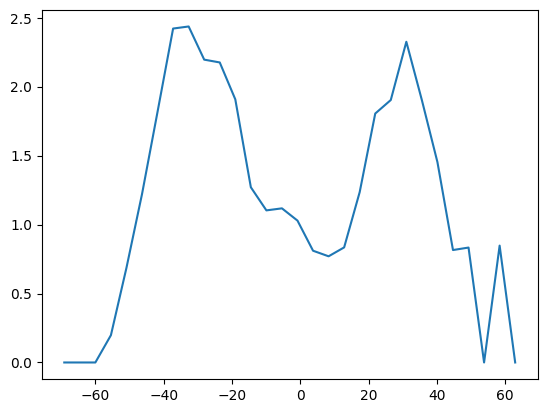

In [289]:
#Hand velocity over the x direction
neuron = 115

#Data preparation
ts_dict = {}
tsd_dict = {}

# Extract spike timestamps and create Ts objects
for i, column in enumerate(df.columns):
    if column.startswith('Neuron'):
        #if(not np.isnan(df[column]).any()):
        timeSeries = nap.Tsd(t=np.array(df[column].index)*bin, d=np.array(df[column], dtype=int), time_units='ms')
        spike_times = timeSeries.index[timeSeries.values > 0]
        tsd_dict[i] = timeSeries
        ts_dict[i] = nap.Ts(t=spike_times)

tsd_group = nap.TsGroup(tsd_dict)
ts_group = nap.TsGroup(ts_dict)

feature = nap.Tsd(df['bump_dir'].index*bin, df['hand_vel_x'], time_units='ms')

tune = nap.process.tuning_curves.compute_1d_tuning_curves(ts_group, feature, 30)

plt.plot(tune.index, tune[neuron])

/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/core/utils.py:186: UserWarning: Converting 't' to numpy.array. The provided array was of type 'Index'.
  warnings.warn(
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/core/utils.py:186: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'Series'.
  warnings.warn(


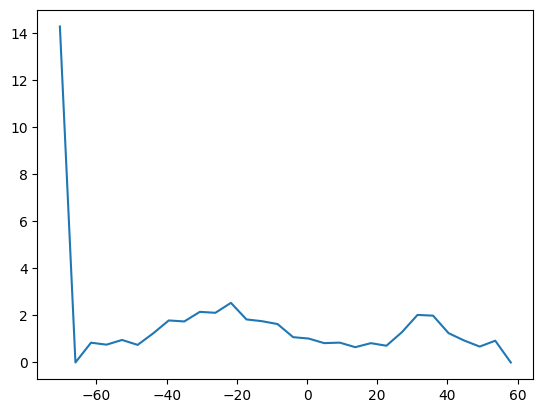

In [243]:
#Hand velocity over the y direction
neuron = 115

#Data preparation
ts_dict = {}
tsd_dict = {}

# Extract spike timestamps and create Ts objects
for i, column in enumerate(df.columns):
    if column.startswith('Neuron'):
        #if(not np.isnan(df[column]).any()):
        timeSeries = nap.Tsd(t=np.array(df[column].index)*bin, d=np.array(df[column], dtype=int), time_units='ms')
        spike_times = timeSeries.index[timeSeries.values > 0]
        tsd_dict[i] = timeSeries
        ts_dict[i] = nap.Ts(t=spike_times)

tsd_group = nap.TsGroup(tsd_dict)
ts_group = nap.TsGroup(ts_dict)

feature = nap.Tsd(df['bump_dir'].index*bin, df['hand_vel_y'], time_units='ms')

tune = nap.process.tuning_curves.compute_1d_tuning_curves(ts_group, feature, 30)

plt.plot(tune.index, tune[neuron])

##### Tuning Curve 2D - Hand Velocity

/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/core/utils.py:186: UserWarning: Converting 't' to numpy.array. The provided array was of type 'Index'.
  warnings.warn(
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/core/utils.py:186: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'Series'.
  warnings.warn(
/Users/guilhermec.f/anaconda3/envs/NeuroTask/lib/python3.11/site-packages/pynapple/process/tuning_curves.py:223: RuntimeWarning: invalid value encountered in divide
  count = count / occupancy


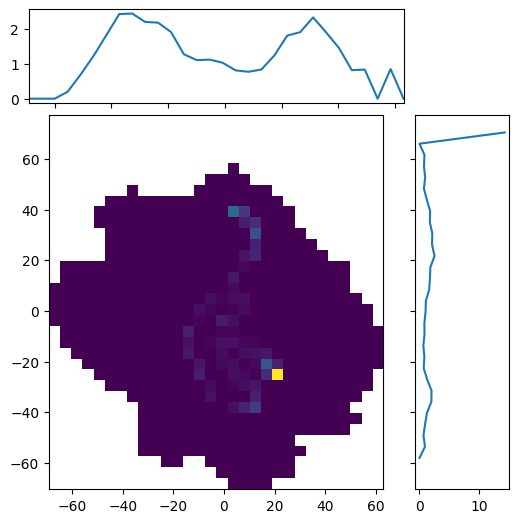

In [291]:
dataframe = df
neuron = 115
resolution = 30
save = False

ts_dict = {}

# Extract spike timestamps and create Ts objects
for i, column in enumerate(dataframe.columns):
    if column.startswith('Neuron'):
        timeSeries = nap.Tsd(t=np.array(dataframe[column].index)*bin, d=np.array(dataframe[column], dtype=int), time_units='ms')
        spike_times = timeSeries.index[timeSeries.values > 0]
        ts_dict[i] = nap.Ts(t=spike_times)

ts_group = nap.TsGroup(ts_dict)

feature_x = dataframe['hand_vel_x']
feature_y = dataframe['hand_vel_y']

#features = np.vstack((feature_x, feature_y))
features = np.stack((feature_x, feature_y), axis=-1)
feature_frame = nap.TsdFrame(t=dataframe['hand_vel_x'].index*bin, d=features)

feature_x = nap.Tsd(feature_x.index*bin, feature_x, time_units='ms')
feature_y = nap.Tsd(feature_y.index*bin, feature_y, time_units='ms')

tune_y = nap.process.tuning_curves.compute_1d_tuning_curves(ts_group, feature_y, resolution)
tune_x = nap.process.tuning_curves.compute_1d_tuning_curves(ts_group, feature_x, resolution)
tune_2d = nap.process.tuning_curves.compute_2d_tuning_curves(ts_group, feature_frame, resolution)

grids = np.meshgrid(tune_2d[1][0], tune_2d[1][1])

value_2d = tune_2d[0][neuron]
value_y = tune_y[neuron]
value_x = tune_x[neuron]

def scatter_hist(value_x, value_y, value_2d, ax, ax_histx, ax_histy, grids, x_values, y_values):
    #unpacking
    grid_x, grid_y = grids
    minimum_x = np.min(grid_x)
    minimum_y = np.min(grid_y)
    maximum_x = np.max(grid_x)
    maximum_y = np.max(grid_y)

    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.imshow(value_2d, extent=(minimum_x, maximum_x, minimum_y, maximum_y))

    ax_histx.plot(x_values, value_x)
    ax_histy.plot(value_y, -y_values)

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(value_x, value_y, value_2d, ax, ax_histx, ax_histy, grids, tune_2d[1][0], tune_2d[1][1])
if(save): plt.savefig('plot.png')